**Set up notebook:**

In [1]:
#!pip install ipympl

In [2]:
#@title Import required libraries for this notebook
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import re
from sklearn.metrics import mean_squared_error
import math

# #to be used in google colab
# from google.colab import files
# from google.colab import output
# output.enable_custom_widget_manager()

pd.set_option('display.max_rows', 200)

In [3]:
#@title Define input source for data
i = input('Input data source. 1 -> Google Drive   2 -> Local storage: ')

if i=='1':
  #Configure Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  #Path to dataset folder
  data_folder = '/content/drive/My Drive/MA/'

elif i=='2':
  #Upload files from local storage
  from google.colab import files

  uploaded = files.upload()
  data_folder = ''

Input data source. 1 -> Google Drive   2 -> Local storage: 1
Mounted at /content/drive


In [4]:
#====================================================================================================================================================

**Set up helping functions**

In [5]:
#@title get_train_test_data
def get_train_test_data(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end):
  
  train_data = dataset[train_date_start : train_date_end]

  test_data = dataset[test_date_start : test_date_end]

  return train_data, test_data

In [6]:
#@title get_X_Y
def get_X_Y(dataset: pd.DataFrame, y_column):
  #Drop rows with NaN values
  XY = dataset.dropna()
  #Split data to X and Y
  X = XY.drop(y_column, axis=1)
  Y = XY[y_column]

  return X,Y

In [7]:
#@title normalize_X_Y_train
def normalize_X_Y_train(X: pd.DataFrame, Y: pd.DataFrame):
  scaler_input = MinMaxScaler(feature_range=(0, 1))
  scaler_input = scaler_input.fit(X)

  scaler_target = MinMaxScaler(feature_range=(0, 1))
  scaler_target = scaler_target.fit(Y)

  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized, scaler_input, scaler_target

In [8]:
#@title normalize_X_Y_test
def normalize_X_Y_test(X: pd.DataFrame, Y: pd.DataFrame, scaler_input, scaler_target):
  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized

In [9]:
#@title get_trained_reg
def get_trained_reg(x: pd.DataFrame, y: pd.DataFrame):
  return LinearRegression().fit(x, y)

In [10]:
#@title get_trained_MLP
from keras import callbacks
def get_trained_MLP(x: pd.DataFrame, y: pd.DataFrame, model=None, dense_1_shape=10, dense_2_shape=10, dense_3_shape=10, dense_4_shape=10, epochs=100, batch_size=100, verbose=2):
  #Train model further
  if model:
    model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False)
    return model

  #Otherwise, create new model
  model = Sequential([
            Input(x.shape[1]),
            Dense(dense_1_shape, activation='relu'),
            #sigmoid
            #regularization (L2)
            Dense(dense_2_shape, activation='relu'),
            Dense(y.shape[1])
        ])
  model.summary()

  #Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')

  #Train model
  callback = EarlyStopping(monitor='loss', patience=20, mode='min', restore_best_weights=True)
  model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False, callbacks=[callback])

  return model

In [11]:
#@title plot_predicted_vs_true
def plot_predicted_vs_true(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column, hue=None, x_column='index', figsize=(25, 7)):

  #predictions = predictions.rename(columns={y_column : y_column + '_pred'})
  #ground_truth = ground_truth.rename(columns={y_column : y_column + '_true'})
  fig, ax = plt.subplots(figsize=figsize)
  if hue:
    ax.plot(getattr(ground_truth[ground_truth[hue] == False], x_column), ground_truth[ground_truth[hue] == False][y_column], label='Measured signal (not {})'.format(hue), color='blue', marker='o')
    ax.scatter(getattr(ground_truth[ground_truth[hue] == True], x_column), ground_truth[ground_truth[hue] == True][y_column], label='Measured signal ({})'.format(hue), color='darkred', marker='x', s=100)
  else:
    ax.plot(getattr(ground_truth, x_column), ground_truth[y_column], label='Measured signal', color='blue', marker='o')

  ax.plot(getattr(predictions, x_column), predictions[y_column], label='Simulation', color='green')

  ax.grid(True)

  ax.legend()
  ax.set_xlabel('Timestamp')
  ax.set_ylabel( y_column + ' [0C]')

  '''
  df = predictions.join(ground_truth)

  fig = plt.figure(figsize=(25,7))
  sns.lineplot(data=df)
  '''
  '''
  fig, ax = plt.subplots(figsize=(25,7))
  ax.plot(ground_truth.index, ground_truth[y_column], color = 'green')
  ax.plot(predictions.index, predictions[y_column], color = 'blue')

  ax.grid(True)

  ax.legend(['Ground Truth', 'Simulation'])
  ax.set_xlabel('Timestamp')
  ax.set_ylabel(y_column + ' [0C]')
  '''

In [12]:
#@title plot_error
def plot_error(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column):
  fig, ax = plt.subplots(figsize=(25,7))
  errors = ((ground_truth[y_column] - predictions[y_column] ) / ground_truth[y_column]) * 100
  ax.plot(errors, color = 'red')

  ax.grid(True)

  ax.set_xlabel('Timestamp')
  ax.set_ylabel('Error [%]')

  return pd.DataFrame(errors)

In [13]:
#@title implement_pipeline_reg
def implement_pipeline_reg(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  
  #Normalize data
  #x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
  
  #Train model
  print('Training model...')
  model = get_trained_reg(X_train, Y_train)

  #Calculate errors
  predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=X_train.index)
  errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

  predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=X_test.index)
  errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

  #Evaluate model
  #x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
  print('Evaluating model...')
  # print('Score for training data: ', model.score(X_train, Y_train))
  # print('Score for test data: ', model.score(X_test, Y_test))
  print('RMSE Train: ', math.sqrt(mean_squared_error(Y_train[y_column], predictions_train[y_column])))
  print('RMSE Test: ', math.sqrt(mean_squared_error(Y_test[y_column], predictions_test[y_column])))

  return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model


In [14]:
#@title implement_pipeline_mlp
def implement_pipeline_mlp(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None,
                           model=None, dense_1_shape=32, dense_9_shape=16, epochs=10, batch_size=100, verbose=2, normalize=False):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  
  if normalize:
    #Normalize data
    x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
    
    #Train model
    print('Training model...')
    model = get_trained_MLP(x_train, y_train, epochs=epochs)

    x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)

    #Calculate errors
    predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    #Evaluate model
    #x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
    print('Evaluating model...')
    # print('Score for training data: ', model.score(X_train, Y_train))
    # print('Score for test data: ', model.score(X_test, Y_test))
    print('RMSE Train: ', math.sqrt(mean_squared_error(Y_train[y_column], predictions_train[y_column])))
    print('RMSE Test: ', math.sqrt(mean_squared_error(Y_test[y_column], predictions_test[y_column])))

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model, scaler_input, scaler_target


  else:
    #Train model
    print('Training model...')
    model = get_trained_MLP(X_train, Y_train, epochs=epochs)

    #Evaluate model
    print('Evaluating model...')
    print('Score for training data: ', model.evaluate(X_train, Y_train))
    print('Score for test data: ', model.evaluate(X_test, Y_test))

    #Calculate errors
    predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=X_train.index)
    #predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=X_test.index)
    #predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model

  


In [15]:
#@title remove_duplicates
def remove_duplicates(list_with_duplicates):
    return list(dict.fromkeys(list_with_duplicates))

In [16]:
#@title kl_divergence
def kl_divergence(p, q):
  epsilon = 1e-10
  p += epsilon
  q += epsilon
  return np.sum(p * np.log(p / q))

In [17]:
#@title get_log_feature
def get_log_feature(logs: pd.DataFrame, log_msg_column, string_query):
  filtered_logs = logs[logs[log_msg_column].str.contains(string_query).fillna(False)]
  index = filtered_logs.index.name
  filtered_logs = filtered_logs.reset_index().drop_duplicates().set_index(index)

  log_feature = filtered_logs[log_msg_column].str.findall(string_query + ' *(\d)*').apply(lambda row: int(row[0]))

  return log_feature

In [18]:
#@title get_log_features
def get_log_features(logs: pd.DataFrame, log_msg_column, string_query):
  feats = logs[logs[log_msg_column].str.contains(string_query, case=False, na=False)][log_msg_column]
  feats = pd.DataFrame(feats.apply(lambda row: row.split(',')[0]))
  feats = feats[log_msg_column].str.rsplit('.', 1, expand=True).rename(columns = {0 : 'name', 1 : 'value'})
  feats.value = feats.value.astype(int)
  feats = feats.pivot(columns='name', values='value')
  return list(feats.columns), feats

In [19]:
#@title get_target_columns
def get_target_columns(all_columns, string_query_list):
  import pandas as pd

  filtered_columns = pd.Series(all_columns)
  for string_query in string_query_list:
    filtered_columns = filtered_columns[filtered_columns.str.contains(string_query)]
  return list(filtered_columns)

In [20]:
#@title append_relevant_log_warnings
def append_relevant_log_warnings(Y: pd.DataFrame, logs: pd.DataFrame, log_msg_column, target_feature_name, filter_by=None, max_distance='24H'):
  relevant_logs = logs[logs[log_msg_column].str.contains(target_feature_name.split('_Temp')[0].replace('_', ' '), na=False, case=False)]

  Y['logs_found'] = None
  for index, row in Y[Y[filter_by]].iterrows() if filter_by else Y.iterrows():
    filtered_logs = relevant_logs[(index - pd.Timedelta(max_distance)) : index]
    if not filtered_logs.empty:
      string = ''
      for i, r in filtered_logs.iterrows():
        string = string + r[log_msg_column] + ' @ ' + str(i) + '\n '
      Y.loc[index, 'logs_found'] = string

    else:
      Y.loc[index, 'logs_found'] = 'No logs found'
    
  return Y

In [21]:
#@title plot_log_warnings
def plot_log_warnings(gt: pd.DataFrame, anomaly_column_name, log_column_name, target_feature, replacement_message = ' '):
  last_logs_found = ''
  for line in range(0, gt.shape[0], 1):
    if gt[anomaly_column_name][line] and gt[log_column_name][line] != last_logs_found:
      plt.text(gt.index[line], gt[target_feature][line], gt[log_column_name][line], size='small', color='black', weight='semibold', rotation=30)
      last_logs_found = gt[log_column_name][line]

    elif gt[log_column_name][line] == replacement_message:
        plt.text(gt.index[line], gt[target_feature][line], '!!{}!!'.format(replacement_message), size='medium', color='darkred', weight='bold', rotation=30)

In [22]:
#@title plot_control_signals
def plot_control_signals(x: pd.DataFrame, log_feature_name):
  last_value = -1
  for ix, row in x.iterrows():
    if str(row[log_feature_name]) == 'nan':
      plt.axvline(x=ix, linestyle='-', color='grey', label='Day Separator')
      last_value = -1
    if row[log_feature_name] != last_value:
      if row[log_feature_name] == 0.0:
        plt.axvline(x=ix, linestyle='--', color='darkred', label='{} 0'.format(log_feature_name))
      elif row[log_feature_name] == 1:
        plt.axvline(x=ix, linestyle='--', color='green', label='{} 1'.format(log_feature_name))
      elif row[log_feature_name] == 2:
        plt.axvline(x=ix, linestyle='--', color='black', label='{} 2'.format(log_feature_name))
      
      last_value=row[log_feature_name]

**Data preprocessing...**

**Load dataset:**

In [23]:
#Read WTG data
signals = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'

#Read Signals data for all turbines and set timestamp as index
all_data = pd.concat([pd.read_csv(data_folder + signals, delimiter=';'), pd.read_csv(data_folder + signals_test, delimiter=';')], ignore_index=True)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data.set_index('Timestamp', inplace=True)


#Read log data
logs = 'wind-farm-1-logs-training.csv'
logs_test = 'wind-farm-1-logs-testing.csv'

#Read logs from all turbines and set TimeDetected as index
log_data = pd.concat([pd.read_csv(data_folder + logs, delimiter=';'), pd.read_csv(data_folder + logs_test, delimiter=';')], ignore_index=True)
log_data['TimeDetected'] = pd.to_datetime(log_data['TimeDetected'])
log_data.set_index('TimeDetected', inplace=True)

#Target/Test turbine: Filter T_09 data out
T09_data = all_data[all_data.Turbine_ID == 'T09']
log_data_T09 = log_data[log_data['UnitTitle'] == 'T09']

#Reference/Validation turbine: Filter T_01 data out
T01_data = all_data[all_data.Turbine_ID == 'T01']
log_data_T01 = log_data[log_data['UnitTitle'] == 'T01']

#Remove duplicates in Timestamp index: Usually occurs at daylight saving
T09_data = T09_data[~T09_data.index.duplicated(keep='first')]
T01_data = T01_data[~T01_data.index.duplicated(keep='first')]

**Extract log feature:**

In [24]:
#Extract log feature
log_feat_T01 = log_data_T01[(log_data_T01.Remark == 'Run') | 
                            (log_data_T01.Remark.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) | 
                            (log_data_T01.Remark.str.contains('new SERVICE state', case=False, na=False))
                            ].Remark
log_feat_T01.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


array(['Pause   -4.5kW     0RPM', 'New SERVICE state: 1,    0',
       'New SERVICE state: 0,    0', 'Run', 'Pause   -8.3kW   131RPM',
       'Pause   -7.5kW   187RPM', 'Pause   -2.1kW   212RPM',
       'Pause   -2.1kW   165RPM', 'Pause   30.0kW  1255RPM',
       'Pause   55.7kW  1243RPM', 'Pause   -3.3kW     0RPM',
       'Stop   -3.0kW     0RPM', 'Stop    0.0kW     0RPM',
       'Pause    0.0kW     0RPM', 'Pause  667.9kW  1559RPM',
       'Pause   -7.5kW  1250RPM', 'Pause   -5.9kW    59RPM',
       'Pause   -7.0kW    55RPM', 'Pause  526.0kW  1398RPM',
       'Pause  370.7kW  1387RPM', 'Pause  488.5kW  1408RPM',
       'Pause  -11.9kW   134RPM', 'Pause 1998.3kW  1675RPM',
       'Pause  175.1kW  1276RPM', 'Stop  -49.9kW  1079RPM',
       'Pause  599.0kW  1582RPM', 'Stop   -5.7kW    75RPM',
       'Pause   -2.5kW     0RPM', 'Pause   -9.7kW  1219RPM',
       'Stop  713.1kW  1081RPM', 'Pause 2003.8kW  1676RPM',
       'Stop 2000.8kW  1671RPM', 'Stop  690.9kW  1637RPM',
       'Stop   -7.

In [25]:
log_feat_T01.loc[(log_feat_T01 == 'Run') | 
                 (log_feat_T01.str.contains('External power ref', case=False, na=False)) | 
                 (log_feat_T01.str.contains('new SERVICE state: 1', case=False, na=False))
                 ] = 1
log_feat_T01.loc[(log_feat_T01.str.contains('(Stop|Pause).*kW.*RPM', case=False, na=False)) | 
                 (log_feat_T01.str.contains('new SERVICE state: 0', case=False, na=False))
                 ] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()


In [44]:
log_feat_T01

TimeDetected
2016-01-19 08:19:43+00:00    0
2016-01-19 08:19:46+00:00    1
2016-01-19 10:38:23+00:00    0
2016-01-19 10:48:51+00:00    1
2016-01-20 12:48:56+00:00    0
                            ..
2017-12-28 01:41:32+00:00    1
2017-12-31 13:07:04+00:00    1
2017-12-31 13:07:52+00:00    0
2017-12-31 13:11:07+00:00    0
2017-12-31 13:11:09+00:00    1
Name: Remark, Length: 675, dtype: object

**Append log feature to signals:**

In [27]:
#Append log feature to signals
T01_data_logs = pd.merge_asof(T01_data, log_feat_T01, left_index = True, right_index = True).fillna(method='ffill')
T01_data_logs['Remark'] = T01_data_logs['Remark'].fillna(1 - T01_data_logs[T01_data_logs['Remark'].notnull()].iloc[0]['Remark'])

In [28]:
T01_data_logs[T01_data_logs.Remark == 0].count()

Turbine_ID                     5467
Gen_RPM_Max                    5467
Gen_RPM_Min                    5467
Gen_RPM_Avg                    5467
Gen_RPM_Std                    5467
Gen_Bear_Temp_Avg              5467
Gen_Phase1_Temp_Avg            5467
Gen_Phase2_Temp_Avg            5467
Gen_Phase3_Temp_Avg            5467
Hyd_Oil_Temp_Avg               5467
Gear_Oil_Temp_Avg              5467
Gear_Bear_Temp_Avg             5467
Nac_Temp_Avg                   5467
Rtr_RPM_Max                    5467
Rtr_RPM_Min                    5467
Rtr_RPM_Avg                    5467
Amb_WindSpeed_Max              5467
Amb_WindSpeed_Min              5467
Amb_WindSpeed_Avg              5467
Amb_WindSpeed_Std              5467
Amb_WindDir_Relative_Avg       5467
Amb_WindDir_Abs_Avg            5467
Amb_Temp_Avg                   5467
Prod_LatestAvg_ActPwrGen0      5467
Prod_LatestAvg_ActPwrGen1      5467
Prod_LatestAvg_ActPwrGen2      5467
Prod_LatestAvg_TotActPwr       5467
Prod_LatestAvg_ReactPwrGen0 

In [29]:
T01_data_logs.corrwith(T01_data_logs['Prod_LatestAvg_TotActPwr'])

Gen_RPM_Max                    0.651659
Gen_RPM_Min                    0.729081
Gen_RPM_Avg                    0.711598
Gen_RPM_Std                   -0.167096
Gen_Bear_Temp_Avg              0.824428
Gen_Phase1_Temp_Avg            0.922963
Gen_Phase2_Temp_Avg            0.909499
Gen_Phase3_Temp_Avg            0.904347
Hyd_Oil_Temp_Avg               0.595899
Gear_Oil_Temp_Avg              0.686370
Gear_Bear_Temp_Avg             0.768679
Nac_Temp_Avg                   0.483228
Rtr_RPM_Max                    0.645994
Rtr_RPM_Min                    0.726535
Rtr_RPM_Avg                    0.707693
Amb_WindSpeed_Max              0.809089
Amb_WindSpeed_Min              0.587144
Amb_WindSpeed_Avg              0.896091
Amb_WindSpeed_Std              0.788905
Amb_WindDir_Relative_Avg      -0.009441
Amb_WindDir_Abs_Avg           -0.217437
Amb_Temp_Avg                   0.150593
Prod_LatestAvg_ActPwrGen0      0.467333
Prod_LatestAvg_ActPwrGen1      0.999986
Prod_LatestAvg_ActPwrGen2           NaN


**EDA...**

In [30]:
#Selected features
#features_w_logs = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg', 'Int_Vent', 'Ext_Vent']
target_features = ['Prod_LatestAvg_TotActPwr']
features_wout_logs = ['Amb_Temp_Avg', 'Amb_WindSpeed_Avg'] + target_features
features_w_logs = features_wout_logs + ['Remark']
target_feature = 'Prod_LatestAvg_TotActPwr'


#Train/Test Periods
train_start_T01 = '2016-09-01'
train_end_T01 = '2016-12-31'
test_start_T01 = '2017-01-01'
test_end_T01 = '2017-12-31'

T01_data_logs.loc[train_start_T01 : train_end_T01, 'dataset'] = 'Train'
T01_data_logs.loc[test_start_T01 : test_end_T01, 'dataset'] = 'Test'

Distribution of Features (T01)

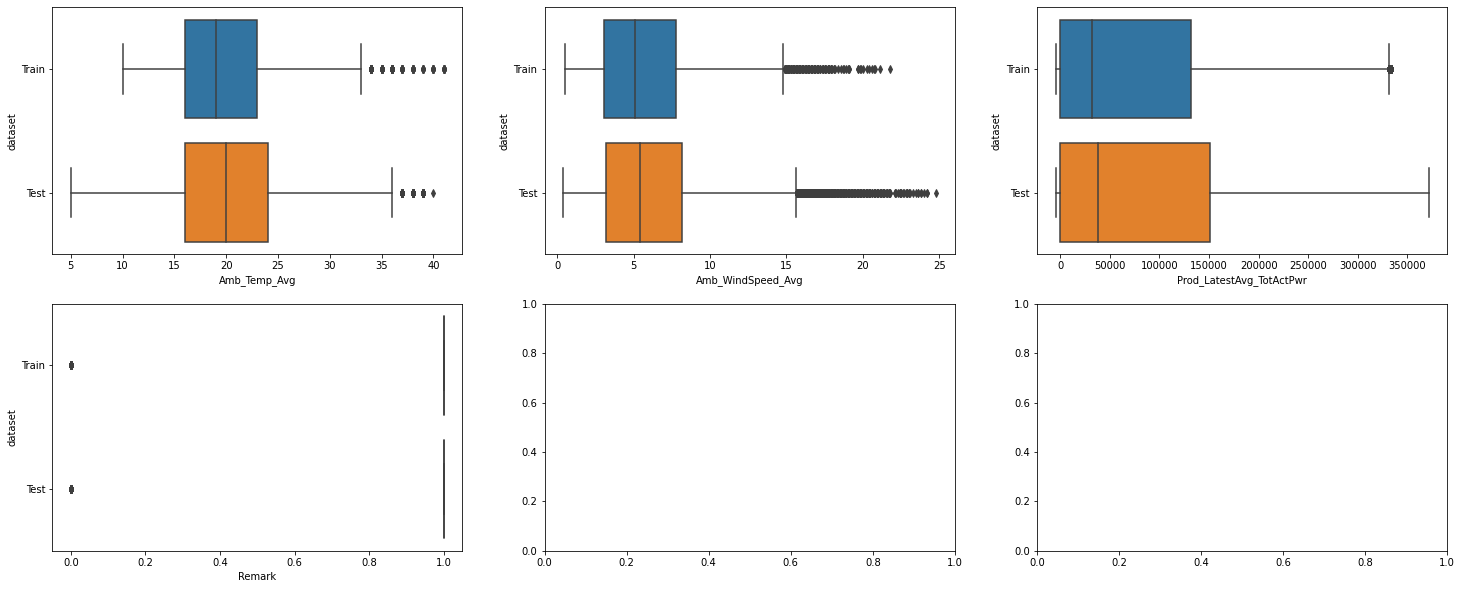

In [31]:
%matplotlib inline
fig, axes = plt.subplots((len(features_w_logs)//3) + 1, 3, figsize=(25,10))
for (i, feature) in zip(range(len(features_w_logs)), features_w_logs):
  sns.boxplot(data = T01_data_logs, x=feature, y='dataset', ax=axes[i//3][i%3])

Correlation of log features with target feature

In [32]:
# dic = [{'turbine' : 'T09', 
#         'Int_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Int_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Int_Vent'],
#         'Ext_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Ext_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Ext_Vent'],
#         'dataset' : 'Train'},
#        {'turbine' : 'T09', 
#         'Int_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Int_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Int_Vent'],
#         'Ext_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Ext_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Ext_Vent'],
#         'dataset' : 'Test'},
#        {'turbine' : 'T01', 
#         'Int_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Int_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Int_Vent'],
#         'Ext_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Ext_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Ext_Vent'],
#         'dataset' : 'Train'},
#        {'turbine' : 'T01', 
#         'Int_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Int_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Int_Vent'],
#         'Ext_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Ext_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Ext_Vent'],
#         'dataset' : 'Test'}]

# corr = pd.DataFrame(dic).set_index('turbine')
# corr

In [33]:
#====================================================================================================================================================

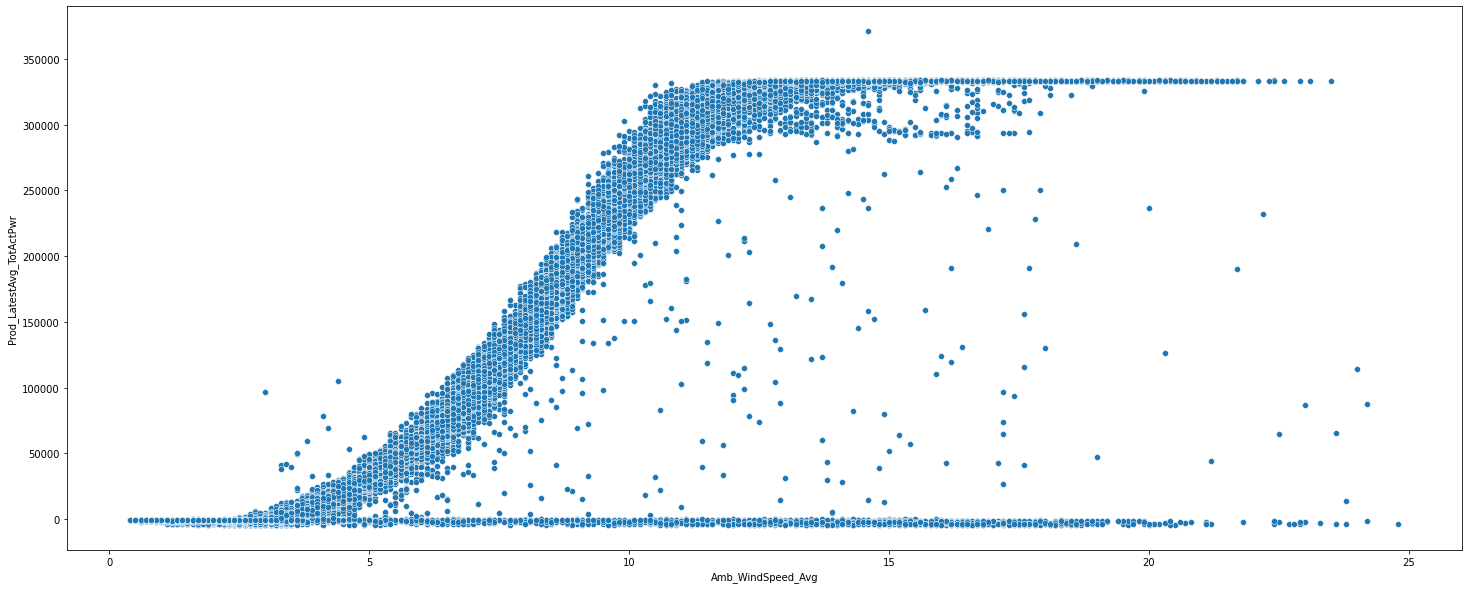

In [34]:
plt.figure(figsize=(25,10))
sns.scatterplot(x='Amb_WindSpeed_Avg', y='Prod_LatestAvg_TotActPwr', data = T01_data_logs)

**NBM for T01(Healthy reference turbine)**

**Deep Learning**

In [35]:
#Train with log features
dataset_1, X_train_1, Y_train_1, predictions_train_1, errors_train_1, X_test_1, Y_test_1, predictions_test_1, errors_test_1, model_1, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
176/176 - 1s - loss: 0.0955 - 926ms/epoch - 5ms/step
Epoch 2/300
176/176 - 0s - loss: 0.0644 - 248ms/epoch - 1ms/step
Epoch 3/300
176/176 - 0s - loss: 0.0380 - 262ms/epoch - 1ms/step
Epoch 4/300
176/176 - 0s - loss: 0.0181 - 277ms/epoch - 2ms/step
Epoch 5/300
176/176 - 0s - loss: 0.0079 - 25

In [36]:
#Train filtered data by log feature
dataset_1_f, X_train_1_f, Y_train_1_f, predictions_train_1_f, errors_train_1_f, X_test_1_f, Y_test_1_f, predictions_test_1_f, errors_test_1_f, model_1_f, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs[T01_data_logs.Remark == 1], train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                30        
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
167/167 - 1s - loss: 0.1593 - 620ms/epoch - 4ms/step
Epoch 2/300
167/167 - 0s - loss: 0.0859 - 240ms/epoch - 1ms/step
Epoch 3/300
167/167 - 0s - loss: 0.0539 - 249ms/epoch - 1ms/step
Epoch 4/300
167/167 - 0s - loss: 0.0240 - 248ms/epoch - 1ms/step
Epoch 5/300
167/167 - 0s - loss: 0.0105 - 

In [37]:
#Train without log features
dataset_1_x, X_train_1_x, Y_train_1_x, predictions_train_1_x, errors_train_1_x, X_test_1_x, Y_test_1_x, predictions_test_1_x, errors_test_1_x, model_1_x, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                30        
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
176/176 - 1s - loss: 0.0487 - 643ms/epoch - 4ms/step
Epoch 2/300
176/176 - 0s - loss: 0.0166 - 256ms/epoch - 1ms/step
Epoch 3/300
176/176 - 0s - loss: 0.0126 - 243ms/epoch - 1ms/step
Epoch 4/300
176/176 - 0s - loss: 0.0110 - 269ms/epoch - 2ms/step
Epoch 5/300
176/176 - 0s - loss: 0.0101 - 

Distribution of errors

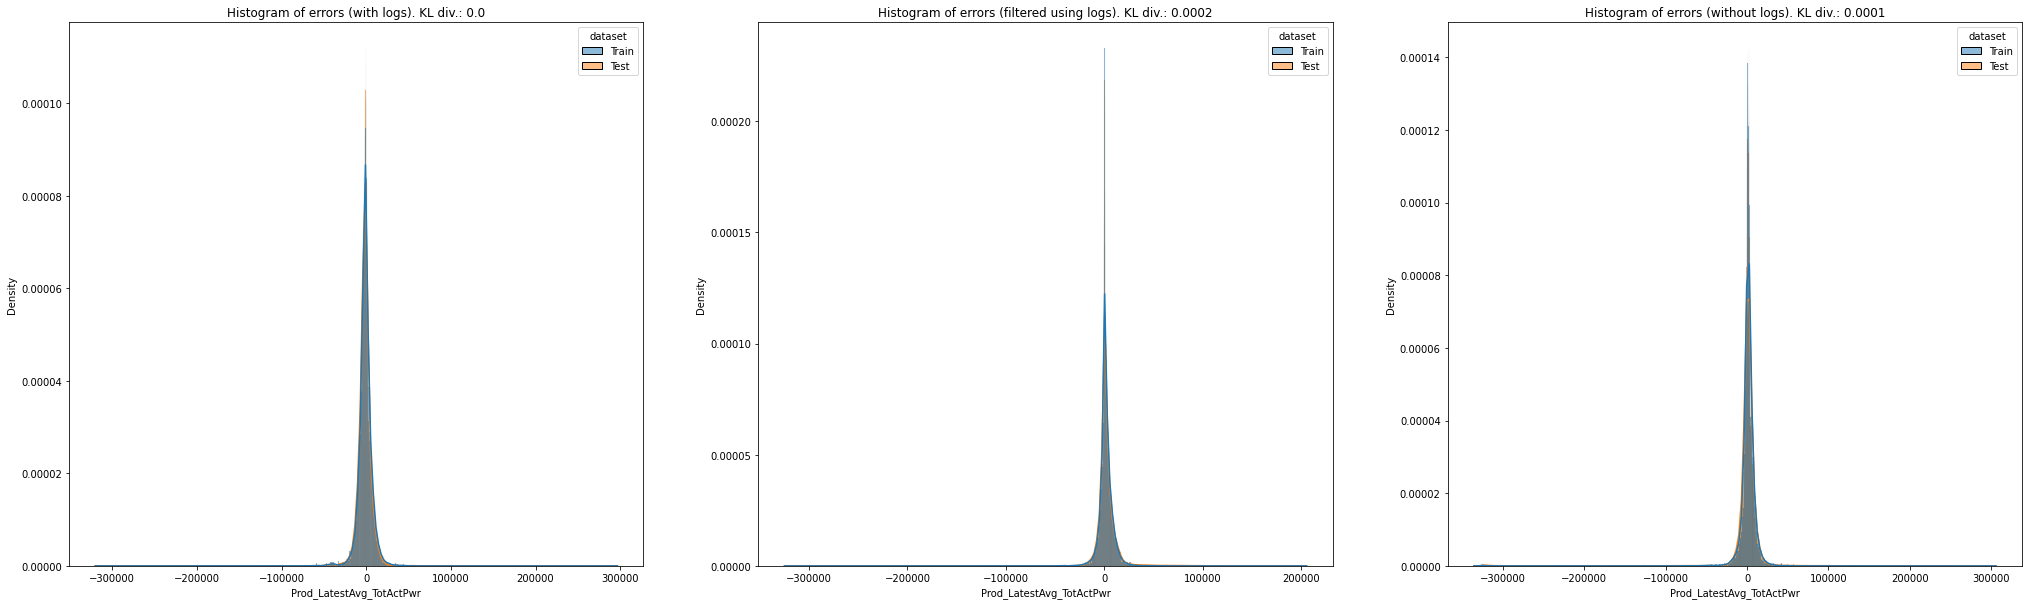

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(35,10))
errors_train_1['dataset'] = 'Train'
errors_test_1['dataset'] = 'Test'

errors_train_1_x['dataset'] = 'Train'
errors_test_1_x['dataset'] = 'Test'

errors_train_1_f['dataset'] = 'Train'
errors_test_1_f['dataset'] = 'Test'

target_feature = target_features[0]

sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_1_f, errors_test_1_f], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
sns.histplot(pd.concat([errors_train_1_x, errors_test_1_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[2])

kl_logs = kl_divergence(np.histogram(errors_train_1[target_feature], density=True)[0], np.histogram(errors_test_1[target_feature], density=True)[0])
kl_filtered = kl_divergence(np.histogram(errors_train_1_f[target_feature], density=True)[0], np.histogram(errors_test_1_f[target_feature], density=True)[0])
kl_no_logs = kl_divergence(np.histogram(errors_train_1_x[target_feature], density=True)[0], np.histogram(errors_test_1_x[target_feature], density=True)[0])

axes[0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
axes[1].set_title('Histogram of errors (filtered using logs). KL div.: {}'.format(round(kl_filtered, 4)));
axes[2].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

**Train with more features**

In [39]:
features_wout_logs = ['Amb_Temp_Avg', 'Amb_WindSpeed_Avg', 'Blds_PitchAngle_Avg', 'Amb_WindDir_Abs_Avg'] + target_features
features_w_logs = features_wout_logs + ['Remark']

In [40]:
#Train with log features
dataset_2, X_train_2, Y_train_2, predictions_train_2, errors_train_2, X_test_2, Y_test_2, predictions_test_2, errors_test_2, model_2, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                60        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
176/176 - 1s - loss: 0.1022 - 640ms/epoch - 4ms/step
Epoch 2/300
176/176 - 0s - loss: 0.0551 - 271ms/epoch - 2ms/step
Epoch 3/300
176/176 - 0s - loss: 0.0353 - 271ms/epoch - 2ms/step
Epoch 4/300
176/176 - 0s - loss: 0.0230 - 265ms/epoch - 2ms/step
Epoch 5/300
176/176 - 0s - loss: 0.0150 - 

In [41]:
#Train with log features
dataset_2_f, X_train_2_f, Y_train_2_f, predictions_train_2_f, errors_train_2_f, X_test_2_f, Y_test_2_f, predictions_test_2_f, errors_test_2_f, model_2_f, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs[T01_data_logs.Remark == 1], train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                50        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
167/167 - 1s - loss: 0.1053 - 639ms/epoch - 4ms/step
Epoch 2/300
167/167 - 0s - loss: 0.0369 - 247ms/epoch - 1ms/step
Epoch 3/300
167/167 - 0s - loss: 0.0149 - 246ms/epoch - 1ms/step
Epoch 4/300
167/167 - 0s - loss: 0.0098 - 251ms/epoch - 2ms/step
Epoch 5/300
167/167 - 0s - loss: 0.0075 - 

In [42]:
#Train without log features
dataset_2_x, X_train_2_x, Y_train_2_x, predictions_train_2_x, errors_train_2_x, X_test_2_x, Y_test_2_x, predictions_test_2_x, errors_test_2_x, model_2_x, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                50        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
176/176 - 1s - loss: 0.0615 - 662ms/epoch - 4ms/step
Epoch 2/300
176/176 - 0s - loss: 0.0272 - 251ms/epoch - 1ms/step
Epoch 3/300
176/176 - 0s - loss: 0.0137 - 251ms/epoch - 1ms/step
Epoch 4/300
176/176 - 0s - loss: 0.0087 - 249ms/epoch - 1ms/step
Epoch 5/300
176/176 - 0s - loss: 0.0069 - 

Distribution of errors

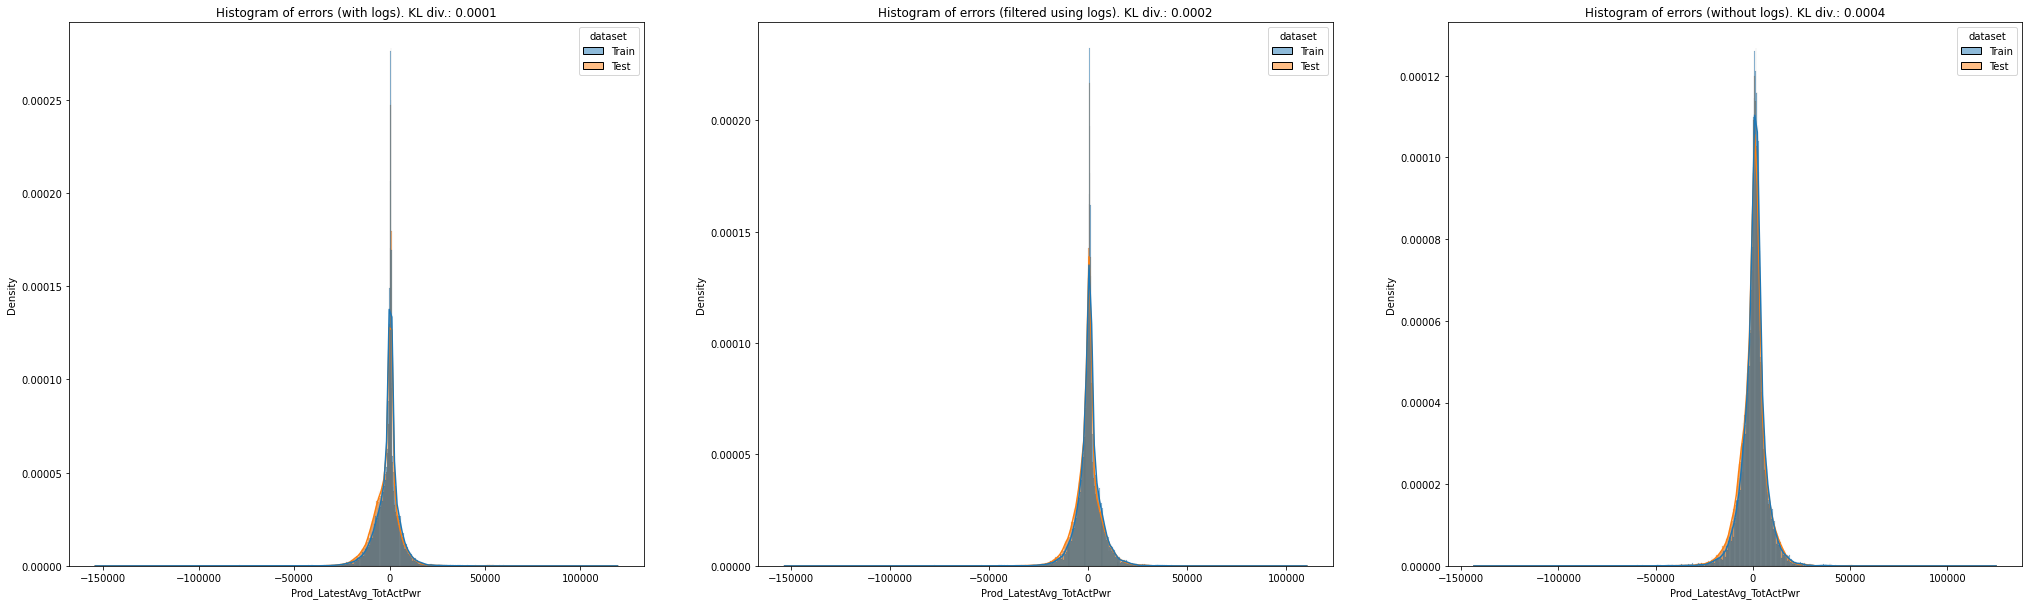

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(35,10))
errors_train_2['dataset'] = 'Train'
errors_test_2['dataset'] = 'Test'

errors_train_2_x['dataset'] = 'Train'
errors_test_2_x['dataset'] = 'Test'

errors_train_2_f['dataset'] = 'Train'
errors_test_2_f['dataset'] = 'Test'

target_feature = target_features[0]

sns.histplot(pd.concat([errors_train_2, errors_test_2], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_2_f, errors_test_2_f], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
sns.histplot(pd.concat([errors_train_2_x, errors_test_2_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[2])

kl_logs = kl_divergence(np.histogram(errors_train_2[target_feature], density=True)[0], np.histogram(errors_test_2[target_feature], density=True)[0])
kl_filtered = kl_divergence(np.histogram(errors_train_2_f[target_feature], density=True)[0], np.histogram(errors_test_2_f[target_feature], density=True)[0])
kl_no_logs = kl_divergence(np.histogram(errors_train_2_x[target_feature], density=True)[0], np.histogram(errors_test_2_x[target_feature], density=True)[0])

axes[0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
axes[1].set_title('Histogram of errors (filtered using logs). KL div.: {}'.format(round(kl_filtered, 4)));
axes[2].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

Anomaly detection (assuming the error distribution is Gaussian for simplification)

In [71]:
anomaly_threshold_1 = errors_train_1[target_feature].mean() + 3 * errors_train_1[target_feature].std()

Y_test_1['Anomaly'] = errors_test_1[target_feature] > anomaly_threshold_1
Y_train_1['Anomaly'] = errors_train_1[target_feature] > anomaly_threshold_1

anomaly_threshold_1_x = errors_train_1_x[target_feature].mean() + 3 * errors_train_1_x[target_feature].std()

Y_test_1_x['Anomaly'] = errors_test_1_x[target_feature] > anomaly_threshold_1_x
Y_train_1_x['Anomaly'] = errors_train_1_x[target_feature] > anomaly_threshold_1_x

print('Anomaly threshold (using log feature): ', anomaly_threshold_1)
print('Anomaly threshold (not using log feature): ', anomaly_threshold_1_x)

Anomaly threshold (using log feature):  23716.933070227973
Anomaly threshold (not using log feature):  20207.396841263537


Append relevant log warning message(s) from the previous 24 hours, if found, to data points labeled as anomaly

In [ ]:
Y_test_1 = append_relevant_log_warnings(Y_test_1, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')
Y_test_1_x = append_relevant_log_warnings(Y_test_1_x, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')

Label data points at time of gen bearing replacement

In [ ]:
Y_test_1.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_1.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

Y_test_1_x.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_1_x.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

#Add date column
Y_test_1['date'] = pd.to_datetime(Y_test_1.index.date)
Y_test_1_x['date'] = pd.to_datetime(Y_test_1_x.index.date)

Extract days where at least one anomaly was detected to visualize data

In [ ]:
#gt -> ground truth, pr -> predictions, x -> input features
gt_1 = Y_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()
pr_1 = predictions_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()
x_1 = X_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


All anomalies detected by model_1 (NBM with log features) (click on img to zoom)

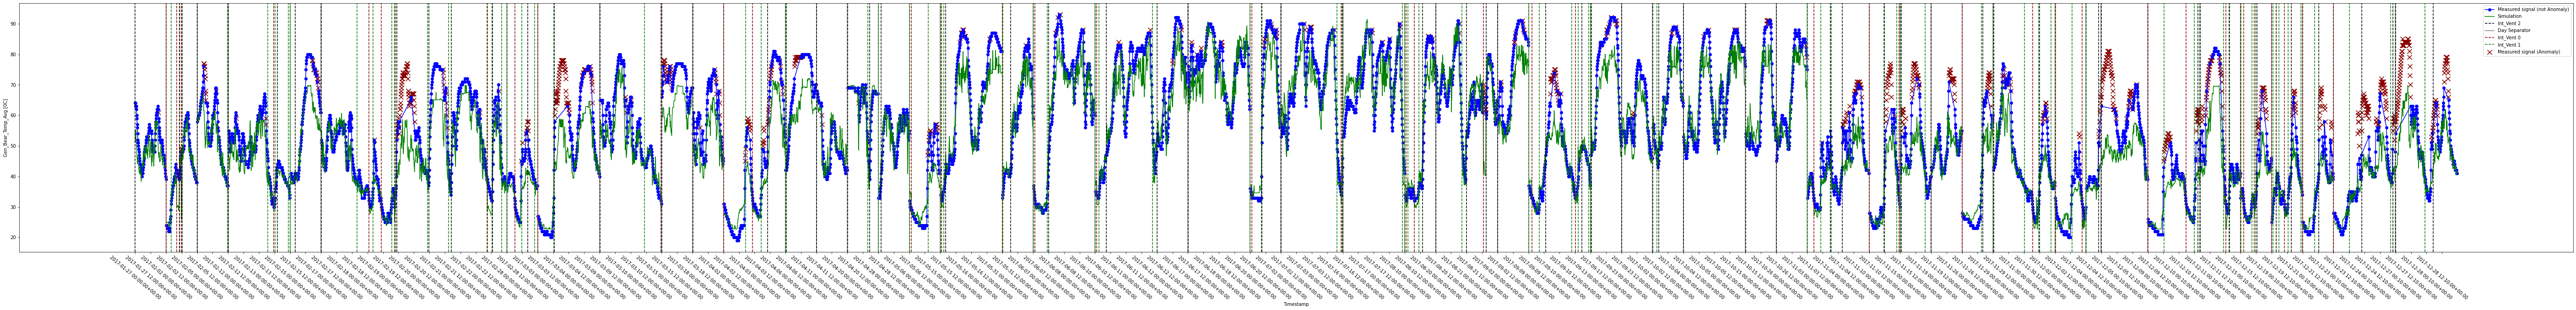

In [ ]:
plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1 (NBM with log features) and not by model_1_x (NBM without log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


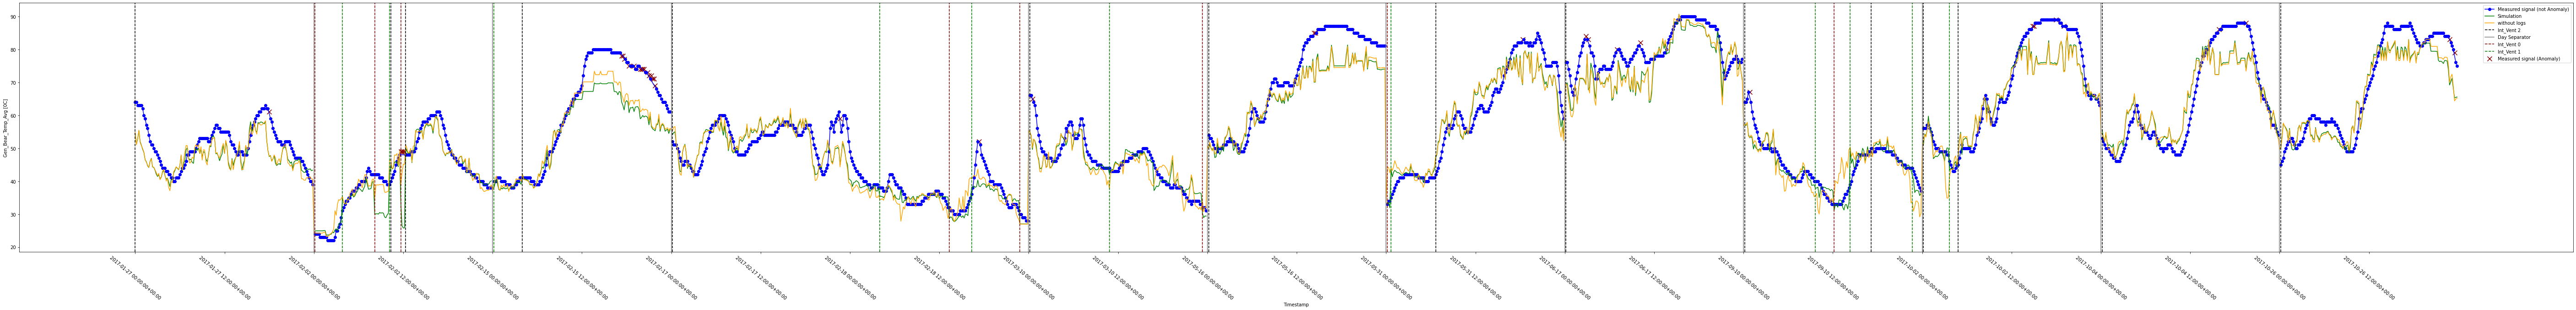

In [ ]:
ixes = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))) & ~(Y_test_1.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date)))

gt_1 = Y_test_1[ixes].reset_index()
pr_1 = predictions_test_1[ixes].reset_index()
x_1 = X_test_1[ixes].reset_index()

pr_1_x = predictions_test_1_x[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1_x.index, pr_1_x[target_feature], color='orange', label='without logs')
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1_x (NBM without log features) and not by model_1 (NBM with log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


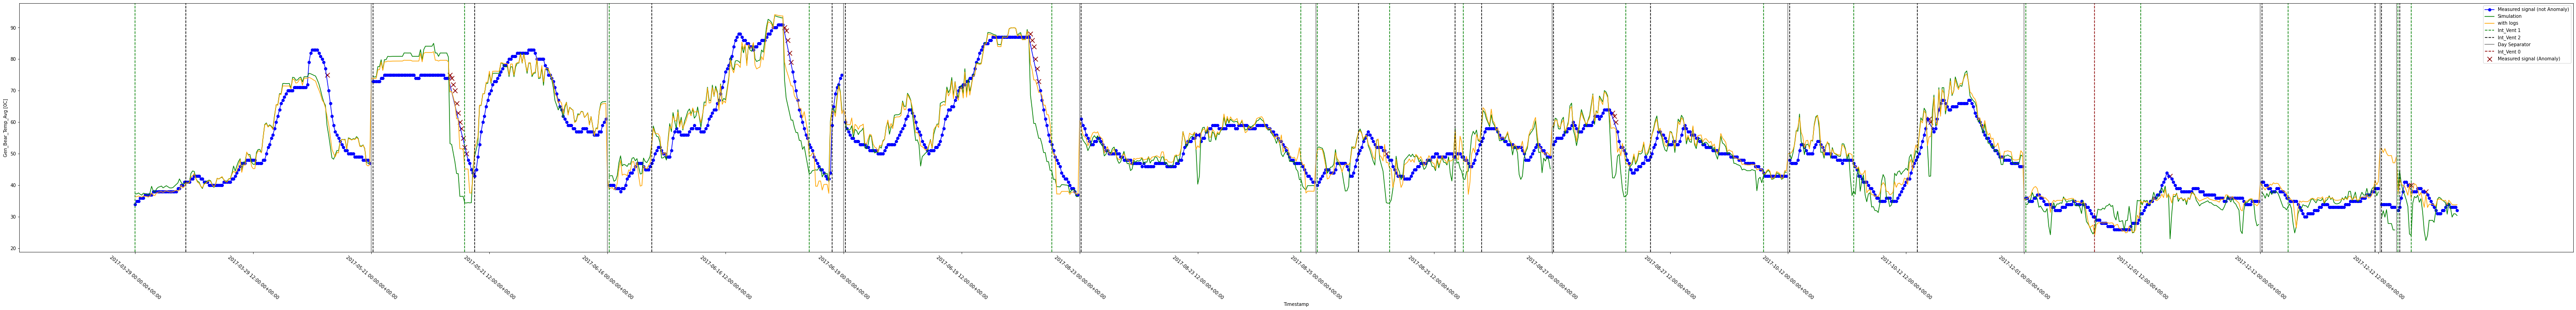

In [ ]:
ixes = (Y_test_1_x.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date))) & ~(Y_test_1_x.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date)))

gt_1_x = Y_test_1_x[ixes].reset_index()
pr_1_x = predictions_test_1_x[ixes].reset_index()
x_1_x = X_test_1[ixes].reset_index()

pr_1 = predictions_test_1[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1_x.loc[x_1_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1_x, gt_1_x, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1.index, pr_1[target_feature], color='orange', label='with logs')
plot_control_signals(x_1_x, 'Int_Vent')

plt.xticks(range(0, gt_1_x.shape[0], 72), labels = gt_1_x['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());